In [1]:
from model.vae_model import VAutoencoder
from model.predict_reconstruct import RNN_VAE
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

2024-07-01 10:08:45.305673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 10:08:50.788637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
sequence_length = 30
input_size = 66
hidden_size = 512#64#1024
num_layers = 2
batch_size = sequence_length # set to the number of images of a seqence # 36
num_epoches = 300
learning_rate = 0.01
latent_zz = 16
device = torch.device('cuda' if torch.cuda.is_available else'cpu')
path = "/home/wetu/bmo/Thesis_Research/data/mean_std/"
seq_max = "seq_max.npy"
seq_min = "seq_min.npy"
mean = np.load(path+'seq_mean.npy')
std = np.load(path+'seq_std.npy')


In [3]:
data_path = "/home/wetu/bmo/Thesis_Research/keypoints_array.npy"
keypoints = np.load(data_path)
print(keypoints.shape)
keypoints = keypoints.reshape(-1,66)
scaler = MinMaxScaler()

# Fit scaler on the data
scaler.fit(keypoints)

# Normalize the data
normalized_data = scaler.transform(keypoints)



(47742, 33, 2)


In [4]:
#keypoints using MP holistics
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
# create meiapip detection function
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results
#draw landmarks
def draw_styled_landmarks(image, results):
    '''mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )'''
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
    return image
import numpy as np

def extract_keypoints(results):
    # Extracts x and y coordinates if pose landmarks are available
    if results.pose_landmarks:
        pose = np.array([[res.x, res.y] for res in results.pose_landmarks.landmark]).flatten()
    else :
        pose = np.zeros(66)
    return pose
future_steps = 15
dropout_encoder = 0.5
dropout_rec = 0.5
dropout_pred = 0.5
softplus = False

In [ ]:

model = RNN_VAE(input_size,future_steps, hidden_size,num_layers,dropout_encoder, dropout_rec,dropout_pred, softplus)
model = model.to(device)

In [5]:
model = VAutoencoder(INPUT_SIZE=input_size,HIDDEN_SIZE=hidden_size,LATENT_SIZE=latent_zz,NUM_LAYERS=num_layers,seq_len=sequence_length,DROP_ENC=0.5,DROP_DEC=0.5)
model.to(device)
print(model)

/home/wetu/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


VAutoencoder(
  (encoder): Encoder(
    (encoder_rnn): GRU(66, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (latent_lam): Lambda(
    (hid2mean): Linear(in_features=2048, out_features=16, bias=True)
    (hid2var): Linear(in_features=2048, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (rnn_rec): GRU(16, 512, batch_first=True, dropout=0.5, bidirectional=True)
    (latent_hid): Linear(in_features=16, out_features=1024, bias=True)
    (output_layer): Linear(in_features=1024, out_features=66, bias=True)
  )
)


In [15]:
n_components = 2
perplexity =30

in_dir = "/home/wetu/bmo/Thesis_Research/keypoint_hidden_arrayvae.npy"
#in_dir = "keypoint_hidden_arrayvae.npy"
movements = np.load(in_dir)
print(movements.shape)

tsne = manifold.TSNE(n_components=n_components, init='random', n_iter=5000,
                        random_state=0, perplexity=perplexity)
X = tsne.fit_transform(movements)


(8563, 16)


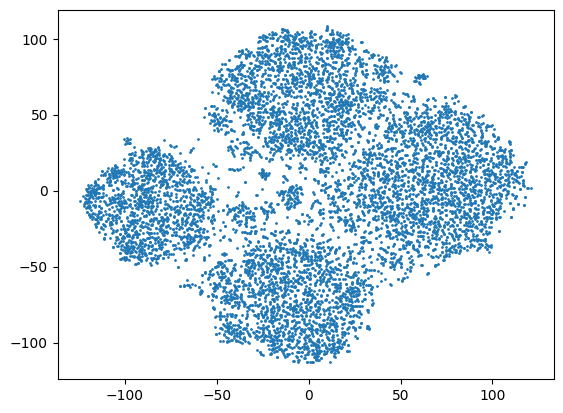

In [16]:
plt.scatter(X[:,0],X[:,1],s = 1)
plt.axis('tight')

plt.show()

In [17]:
model_path = "/home/wetu/bmo/Thesis_Research/lstm_autoencoder_model_aa.pt"
#model_path = "lstm_autoencoder_model_aa.pt"
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
model.eval()

VAutoencoder(
  (encoder): Encoder(
    (encoder_rnn): GRU(66, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  )
  (latent_lam): Lambda(
    (hid2mean): Linear(in_features=2048, out_features=16, bias=True)
    (hid2var): Linear(in_features=2048, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (rnn_rec): GRU(16, 512, batch_first=True, dropout=0.5, bidirectional=True)
    (latent_hid): Linear(in_features=16, out_features=1024, bias=True)
    (output_layer): Linear(in_features=1024, out_features=66, bias=True)
  )
)

In [10]:
import torch.onnx
import netron
x = torch.randn(1,30,66).to(device)
torch.onnx.export(model,x,"vae_model.onnx")
netron.start('vae_model.onnx')

/home/wetu/.local/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4476: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Serving 'vae_model.onnx' at http://localhost:8080


('localhost', 8080)

/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_105342/814987925.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,cmap='ranbow', alpha=0.5)


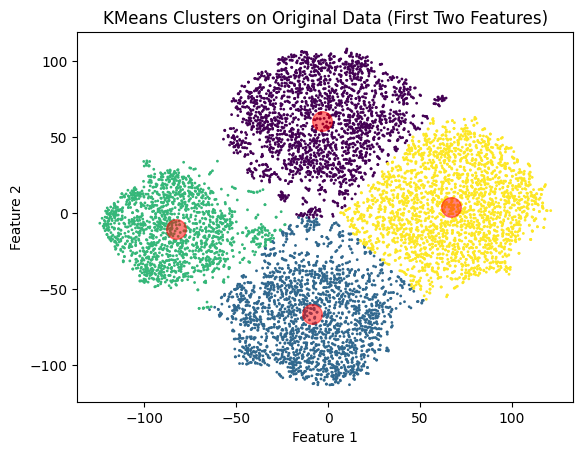

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Example: Creating a random dataset with shape (1102, 32)
# In practice, replace this with your actual data
arr = X
kmeans = KMeans(n_clusters=3)

# Fit the model
kmeans.fit(movements)

# Get the cluster labels
labels = kmeans.labels_

# Optionally, you can also get the coordinates of the cluster centers
centers = kmeans.cluster_centers_
# Apply KMeans clustering with k=5
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
labels = kmeans.labels_

# Scatter plot of the original data
# The first two features (columns) are used for plotting
plt.scatter(arr[:, 0], arr[:, 1], c=labels, cmap='viridis',s=1)

# Plotting the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,cmap='ranbow', alpha=0.5)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clusters on Original Data (First Two Features)')

# Display the plot
plt.show()


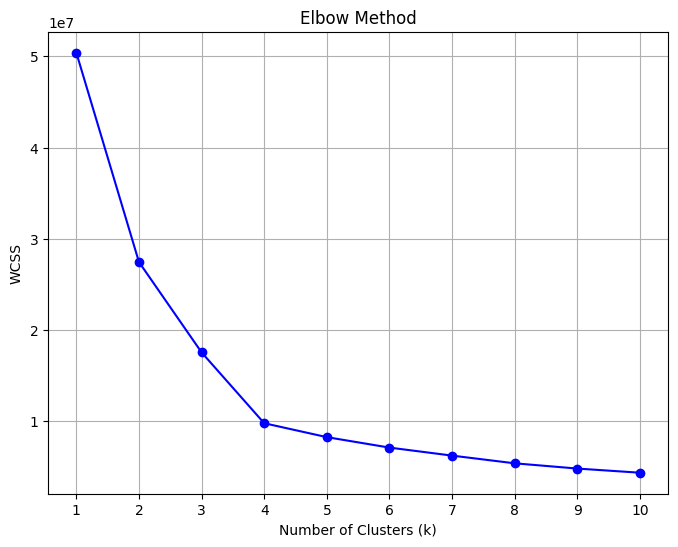

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Calculate within-cluster sum of squares (WCSS) for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # inertia_ contains WCSS value for given k

# Plot the elbow method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


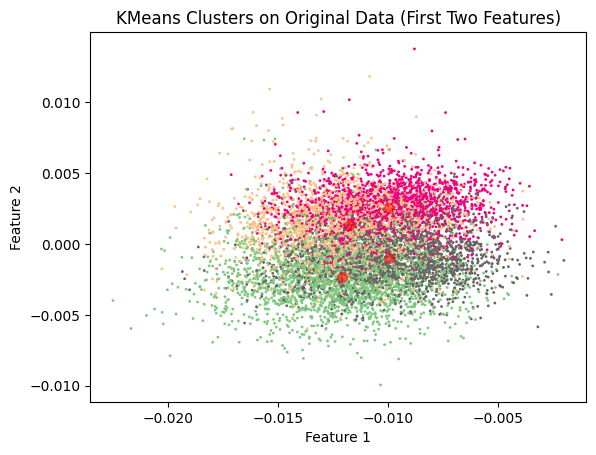

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
# Example: Creating a random dataset with shape (1102, 32)
# In practice, replace this with your actual data
arr = movements
n_clusters = 4
kmeans = KMeans(n_clusters)
kmeans.fit(arr)
labels = kmeans.labels_

plt.scatter(arr[:, 0], arr[:, 1], c=labels, s=1, cmap='Accent_r')

# Plotting the centroids
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50, alpha=0.5)  # Increased size for better visibility

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('KMeans Clusters on Original Data (First Two Features)')

# Display the plot
plt.show()



In [ ]:
import cv2
import mediapipe as mp
import torch

mp_holistic = mp.solutions.holistic
video_path = "/home/wetu/bmo/Thesis_Research/data/video/test/worker_demo5.avi"  # Replace with your video path
extract_hiddd = []
# Initialize video capture
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
model.to(device)
state = []
# Initialize variables
keypoint_sequence = []
sequence_length = 30  # Length of each sequence of keypoints
current_cluster = 0
# Initialize MediaPipe Holistic and your encoder model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if no frame is read

        # Process frame to extract keypoints
        image, results = mediapipe_detection(frame, holistic)  # Assuming this function is defined
        image = draw_styled_landmarks(image, results)
        keypoints = extract_keypoints(results)  # Extract keypoints
        keypoint_sequence.append(keypoints)  # Add extracted keypoints to the sequence

        # Check if sequence is ready
        if len(keypoint_sequence) == sequence_length:
            keypoint_sequence = (keypoint_sequence-mean)/std
            print(f'keypoint seq {keypoint_sequence.shape}')
            # Convert sequence to tensor and reshape as needed
            sequence_tensor = torch.stack([torch.tensor((kp),dtype=torch.float) for kp in keypoint_sequence])
            sequence_tensor = sequence_tensor.reshape(-1, sequence_length, input_size).to(device)
            # Pass sequence through the encoder
            hidd = model.encoder(sequence_tensor.float())
            
            # Use your trained k-means model to classify the encoded sequence
            kmeans_prediction = kmeans.predict(hidd.cpu().detach().numpy())
            current_cluster = kmeans_prediction[0]
            if current_cluster == 0:
                state = "pick up"
            elif current_cluster == 1:
                state = "inspect"
            else:
                state = "storage"
            # Process the prediction as needed...
            extract_hiddd.append(hidd)
            # Reset the sequence
            keypoint_sequence = []

        cv2.putText(image, f'Current Action: {current_cluster}', (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # Show video
        cv2.imshow('Processed Feed', image)
        print()
        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
#Rosie rider QesasTop
# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


In [25]:
mp_holistic = mp.solutions.holistic
video_path = "/home/wetu/bmo/Thesis_Research/data/video/test/worker_demo5.avi"
extract_hiddd = []

cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
model.to(device)
state = []

keypoint_sequence = []
sequence_length = 30  # Adjust according to your model's requirements
frame_idx = 0  # Frame counter to sample every 4 frames
current_cluster = 0


with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % 5 == 0:  # Process every 4th frame
            image, results = mediapipe_detection(frame, holistic)  # Assuming this function is defined
            image = draw_styled_landmarks(image, results)  # Assuming this function is defined
            keypoints = extract_keypoints(results)  # Assuming this function is defined
            keypoint_sequence.append(keypoints)

        if len(keypoint_sequence) == sequence_length:
            print(keypoint_sequence)
            keypoint_array = np.array(keypoint_sequence)
            normalized_keypoints = scaler.transform(keypoint_array)
            sequence_tensor = torch.tensor(normalized_keypoints, dtype=torch.float).to(device)
            sequence_tensor = sequence_tensor.view(-1, sequence_length, sequence_tensor.shape[-1])  # Adjust shape if necessary

            hidd = model.encoder(sequence_tensor.float())
            _,mu,_ = model.latent_lam(hidd)
            kmeans_prediction = kmeans.predict(mu.cpu().detach().numpy())
            current_cluster = kmeans_prediction[0]
            state = ["inspect", "pickup ", "no_action","storage"][current_cluster]
            extract_hiddd.append(hidd)
            keypoint_sequence = []

        cv2.putText(image, f'Current Action: {state}', (50, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.imshow('Processed Feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        frame_idx += 1  # Increment frame counter

cap.release()
out.release()
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x5a98021062e0) is not the object's thread (0x5a9841997e70).
Cannot move to target thread (0x5a98021062e0)

QObject::moveToThread: Current thread (0x5a98021062e0) is not the object's thread (0x5a9841997e70).
Cannot move to target thread (0x5a98021062e0)

QObject::moveToThread: Current thread (0x5a98021062e0) is not the object's thread (0x5a9841997e70).
Cannot move to target thread (0x5a98021062e0)

QObject::moveToThread: Current thread (0x5a98021062e0) is not the object's thread (0x5a9841997e70).
Cannot move to target thread (0x5a98021062e0)

QObject::moveToThread: Current thread (0x5a98021062e0) is not the object's thread (0x5a9841997e70).
Cannot move to target thread (0x5a98021062e0)

QObject::moveToThread: Current thread (0x5a98021062e0) is not the object's thread (0x5a9841997e70).
Cannot move to target thread (0x5a98021062e0)

QObject::moveToThread: Current thread (0x5a98021062e0) is not the object's thread (0x5a9841997e70).
Cannot move to tar

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [15]:
import cv2
import mediapipe as mp
import torch

mp_holistic = mp.solutions.holistic
video_path = "/home/wetu/Downloads/single_angle_HAR/video09.mp4"  # Replace with your video path
extract_hiddd = []
# Initialize video capture
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
model.to(device)
state = []
# Initialize variables
keypoint_sequence = []
sequence_length = 40  # Length of each sequence of keypoints
current_cluster = 0
# Initialize MediaPipe Holistic and your encoder model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if no frame is read

        # Process frame to extract keypoints
        image, results = mediapipe_detection(frame, holistic)  # Assuming this function is defined
        image = draw_styled_landmarks(image, results)
        keypoints = extract_keypoints(results)  # Extract keypoints
        keypoint_sequence.append(keypoints)  # Add extracted keypoints to the sequence

        # Check if sequence is ready
        if len(keypoint_sequence) == sequence_length:
            keypoint_sequence = (keypoint_sequence-mean)/std
            print(f'keypoint seq {keypoint_sequence.shape}')
            # Convert sequence to tensor and reshape as needed
            sequence_tensor = torch.stack([torch.tensor((kp),dtype=torch.float) for kp in keypoint_sequence])
            sequence_tensor = sequence_tensor.reshape(-1, sequence_length, input_size).to(device)
            # Pass sequence through the encoder
            hidd = model.encoder(sequence_tensor.float())
            _,mu,_ = model.latent_lam(hidd)
            
            # Use your trained k-means model to classify the encoded sequence
            kmeans_prediction = kmeans.predict(mu.cpu().detach().numpy())
            current_cluster = kmeans_prediction[0]
            if current_cluster == 0:
                state = "pick up"
            elif current_cluster == 1:
                state = "inspect"
            else:
                state = "storage"
            # Process the prediction as needed...
            extract_hiddd.append(hidd)
            # Reset the sequence
            keypoint_sequence = []

        cv2.putText(image, f'Current Action: {current_cluster}', (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        # Show video
        cv2.imshow('Processed Feed', image)
        print()
        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
#Rosie rider QesasTop
# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
QObject::moveToThread: Current thread (0x6137af1ad4c0) is not the object's thread (0x6137aef8c410).
Cannot move to target thread (0x6137af1ad4c0)

QObject::moveToThread: Current thread (0x6137af1ad4c0) is not the object's thread (0x6137aef8c410).
Cannot move to target thread (0x6137af1ad4c0)

QObject::moveToThread: Current thread (0x6137af1ad4c0) is not the object's thread (0x6137aef8c410).
Cannot move to target thread (0x6137af1ad4c0)

QObject::moveToThread: Current thread (0x6137af1ad4c0) is not the object's thread (0x6137aef8c410).
Cannot move to target thread (0x6137af1ad4c0)

QObject::moveToThread: Current thread (0x6137af1ad4c0) is not the object's thread (0x6137aef8c410).
Cannot move to target thread (0x6137af1ad4c0)

QObject::moveToThread: Current thread (0x6137af1ad4c0) is not the object's thread (0x6137aef8c410).
Cannot move to target thread (0x6137af1ad4c0)

QObject::moveToThread: Current thread (0x6137af1ad4c0) is not 








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)








































keypoint seq (40, 66)









In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming extract_hiddd is a list of PyTorch tensors
# Move each tensor to CPU, detach it from the computational graph, and then convert to NumPy array
extract_hiddd_cpu = [tensor.detach().cpu().numpy() for tensor in extract_hiddd]

# Concatenate the list of arrays into a single NumPy array
extract_hiddd_np = np.concatenate(extract_hiddd_cpu, axis=0)


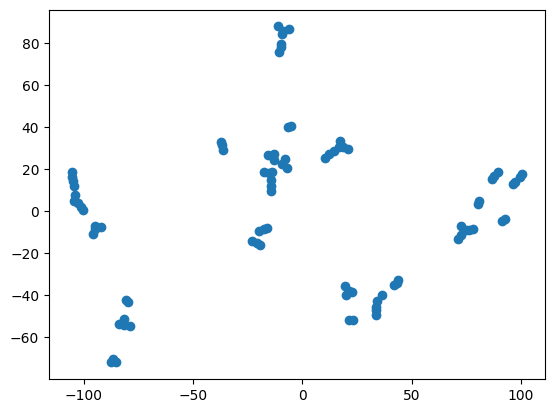

In [15]:

n_components = 2
perplexity =2

tsne = manifold.TSNE(n_components=n_components, init='random', n_iter=5000,
                        random_state=0, perplexity=perplexity)
X_new = tsne.fit_transform(extract_hiddd_np)
plt.scatter(X_new[:, 0], X_new[:, 1])

plt.show()

/home/wetu/anaconda3/envs/yolov7/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


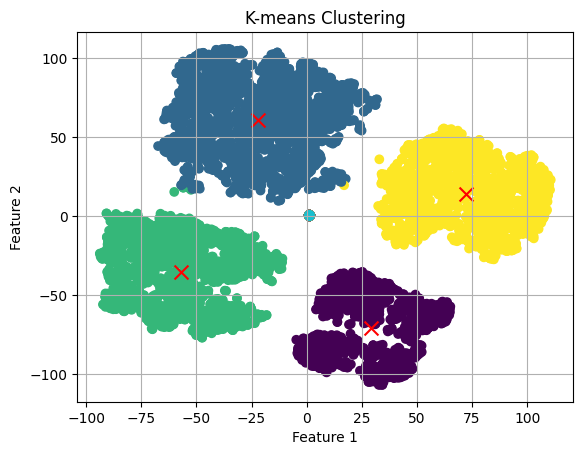

In [17]:
k =4
# Perform K-means clustering on the original data X
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

# Predict cluster labels for new data
predicted_labels = kmeans.predict(X_new)

# Plot the original data points
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', label='Original Data')

# Plot the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=100, c='red', label='Centroids')

# Plot the new data points with their predicted cluster labels
for i, label in enumerate(predicted_labels):
    plt.scatter(extract_hiddd_np[i, 0], extract_hiddd_np[i, 1], marker='o', s=50, label=f'Predicted Cluster {label}')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()


In [ ]:
import cv2
import mediapipe as mp
import torch

mp_holistic = mp.solutions.holistic
video_path = "/home/wetu/bmo/Thesis_Research/worker_demo0.avi"  # Replace with your video path
extract_hiddd = []

# Define transition matrix
transition_matrix = [
    [1, 1, 0],  # State 0 transitions to State 1 or remains in State 0
    [0, 1, 1],  # State 1 transitions to State 2 or remains in State 1
    [1, 0, 1]   # State 2 transitions to State 0 or remains in State 2
]

# Initialize video capture
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
model.to(device)
state = []
# Initialize variables
keypoint_sequence = []
sequence_length = 20  # Length of each sequence of keypoints
current_cluster = 0
previous_cluster = 0
# Initialize MediaPipe Holistic and your encoder model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if no frame is read

        # Process frame to extract keypoints
        image, results = mediapipe_detection(frame, holistic)  # Assuming this function is defined
        image = draw_styled_landmarks(image, results)
        keypoints = extract_keypoints(results)  # Extract keypoints
        keypoint_sequence.append(keypoints)  # Add extracted keypoints to the sequence

        # Check if sequence is ready
        if len(keypoint_sequence) == sequence_length:
            keypoint_sequence = (keypoint_sequence-mean)/std
            # Convert sequence to tensor and reshape as needed
            sequence_tensor = torch.stack([torch.tensor((kp),dtype=torch.float) for kp in keypoint_sequence])
            sequence_tensor = sequence_tensor.reshape(-1, sequence_length, input_size).to(device)
            # Pass sequence through the encoder
            hidd = model.encoder(sequence_tensor.float())
            
            # Use your trained k-means model to classify the encoded sequence
            kmeans_prediction = kmeans.predict(hidd.cpu().detach().numpy())
            current_cluster = kmeans_prediction[0]
            
            # Check for correct transition
            if transition_matrix[previous_cluster][current_cluster] == 1:
                if current_cluster == 0:
                    state = "pick up"
                elif current_cluster == 1:
                    state = "inspect"
                else:
                    state = "storage"
            else:
                # If the transition is not correct, set state to None
                state = None
            
            # Update previous cluster for next iteration
            previous_cluster = current_cluster
            
            # Process the prediction as needed...
            extract_hiddd.append(hidd)
            # Reset the sequence
            keypoint_sequence = []
        
        # Display current action on the video frame if state is not None
        if state is not None:
            cv2.putText(image, f'Current Action: {state}', (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        # Show video
        cv2.imshow('Processed Feed', image)
        out.write(image)
        
        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not 

In [ ]:
import cv2
import mediapipe as mp
import torch

mp_holistic = mp.solutions.holistic
video_path = "/home/wetu/bmo/Thesis_Research/worker_demo0.avi"  # Replace with your video path
extract_hiddd = []

# Define transition matrix
transition_matrix = [
    [1, 1, 0],  # State 0 transitions to State 0 or State 1
    [0, 1, 1],  # State 1 transitions to State 1 or State 2
    [0, 0, 1]   # State 2 transitions to State 2 or State 0
]
correct = None
out_label = None
# Initialize video capture
cap = cv2.VideoCapture(video_path)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (640, 480))
model.to(device)
state = []
# Initialize variables
keypoint_sequence = []
sequence_length = 20  # Length of each sequence of keypoints
current_cluster = 0
previous_cluster = 0
# Initialize MediaPipe Holistic and your encoder model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if no frame is read

        # Process frame to extract keypoints
        image, results = mediapipe_detection(frame, holistic)  # Assuming this function is defined
        image = draw_styled_landmarks(image, results)
        keypoints = extract_keypoints(results)  # Extract keypoints
        keypoint_sequence.append(keypoints)  # Add extracted keypoints to the sequence

        # Check if sequence is ready
        if len(keypoint_sequence) == sequence_length:
            keypoint_sequence = (keypoint_sequence-mean)/std
            print(f'keypoint seq {keypoint_sequence.shape}')
            # Convert sequence to tensor and reshape as needed
            sequence_tensor = torch.stack([torch.tensor((kp),dtype=torch.float) for kp in keypoint_sequence])
            sequence_tensor = sequence_tensor.reshape(-1, sequence_length, input_size).to(device)
            # Pass sequence through the encoder
            hidd = model.encoder(sequence_tensor.float())
            
            # Use your trained k-means model to classify the encoded sequence
            kmeans_prediction = kmeans.predict(hidd.cpu().detach().numpy())
            current_cluster = kmeans_prediction[0]
            
            # Check for correct transition
            if transition_matrix[previous_cluster][current_cluster] == 1:
                if current_cluster == 0:
                    state = "pick up"
                elif current_cluster == 1:
                    state = "inspect"
                else:
                    state = "storage"
                out_label = state
            else:
                # If the transition is not correct, set state to None
                state = None
            
            # Update previous cluster for next iteration
            previous_cluster = current_cluster
            
            # Process the prediction as needed...
            extract_hiddd.append(hidd)
            # Reset the sequence
            keypoint_sequence = []
        
        # Display current action on the video frame if state is not None
        cv2.putText(image, f'Current Action: {out_label}', (50, 50), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        
        # Show video
        cv2.imshow('Processed Feed', image)
        out.write(image)
        
        # Break the loop if 'q' is pressed
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to target thread (0x64f093c216c0)

QObject::moveToThread: Current thread (0x64f093c216c0) is not the object's thread (0x64f0950f2bd0).
Cannot move to tar

keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint seq (20, 66)
keypoint s